In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp


In [2]:
dim_z = 8

In [3]:
prior = tfp.distributions.Independent(
            tfp.distributions.Normal(loc=tf.zeros(dim_z), scale=1.0),
            reinterpreted_batch_ndims=1,
        )
input_img = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(
                filters=32,
                kernel_size=3,
                strides=(2, 2),
                padding="valid",
                activation="relu",
            ) (input_img)
x = layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=(2, 2),
                padding="valid",
                activation="relu",
            ) (x)
x = layers.Flatten()(x)
x = layers.Dense(
                tfp.layers.IndependentNormal.params_size(dim_z),
                activation=None,
                name="z_params",
            )(x)
encoded = tfp.layers.IndependentNormal(
                dim_z,
                activity_regularizer=tfp.layers.KLDivergenceRegularizer(
                    prior, weight=2.0
                ),
                name="z_layer",)(x)

decoder_input = layers.InputLayer(input_shape=dim_z)(encoded)
x = layers.Dense(7 * 7 * 32, activation=None)(decoder_input)
x = layers.Reshape((7, 7, 32))(x)
x = layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding="same", activation="relu"
            )(x)
x = layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding="same", activation="relu"
            )(x)
x = layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding="same")(x)
x = layers.Flatten(name="x_params")(x)
decoded = tfp.layers.IndependentBernoulli((28, 28, 1), name="x_layer")(x)
vae = keras.Model(input_img, decoded)
vae.compile(optimizer='adam', loss=lambda x, y: -y.log_prob(x))
vae.summary()

2022-03-03 15:44:11.676794: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 z_params (Dense)            (None, 16)                36880     
                                                                 
 z_layer (IndependentNormal)  ((None, 8),              0         
                              (None, 8))                         
                                                             

2022-03-03 15:44:11.908012: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [4]:
from stacked_mnist import StackedMNISTData, DataMode
import numpy as np

generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = generator.get_full_data_set(training=True)
x_test, y_test = generator.get_full_data_set(training=False)

# "Translate": Only look at "red" channel; only use the last digit. Use one-hot for labels during training
x_train = x_train[:, :, :, [0]]
y_train = keras.utils.to_categorical((y_train % 10).astype(np.int), 10)
x_test = x_test[:, :, :, [0]]
y_test = keras.utils.to_categorical((y_test % 10).astype(np.int), 10)

/var/folders/w2/4g3c4yrn38g2nwwdhjdlx6fc0000gn/T/ipykernel_17597/4188248072.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = keras.utils.to_categorical((y_train % 10).astype(np.int), 10)
/var/folders/w2/4g3c4yrn38g2nwwdhjdlx6fc0000gn/T/ipykernel_17597/4188248072.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

In [5]:
vae.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
469/469 [==============================] - 32s 65ms/step - loss: 199.0708 - val_loss: 155.7756
Epoch 2/10
469/469 [==============================] - 31s 65ms/step - loss: 151.1450 - val_loss: 146.8572
Epoch 3/10
469/469 [==============================] - 30s 65ms/step - loss: 146.0278 - val_loss: 143.2922
Epoch 4/10
469/469 [==============================] - 31s 66ms/step - loss: 143.2144 - val_loss: 141.1682
Epoch 5/10
469/469 [==============================] - 30s 65ms/step - loss: 141.4784 - val_loss: 140.4079
Epoch 6/10
469/469 [==============================] - 31s 65ms/step - loss: 140.2909 - val_loss: 139.2278
Epoch 7/10
469/469 [==============================] - 31s 66ms/step - loss: 139.4282 - val_loss: 138.1811
Epoch 8/10
469/469 [==============================] - 31s 66ms/step - loss: 138.5748 - val_loss: 137.7445
Epoch 9/10
469/469 [==============================] - 31s 66ms/step - loss: 138.0453 - val_loss: 137.1992
Epoch 10/10
469/469 [=========================

In [15]:
generator = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_random_batch(training=False, batch_size=2000)

In [16]:
reconstructed = np.zeros(x_test.shape)
for i in range(3):
    reconstructed[:,:,:,[i]] = vae(x_test[:,:,:,[i]]).mode()
x_test = x_test.astype(np.float64)

In [17]:
from verification_net import VerificationNet

net = VerificationNet(force_learn=False, file_name="../models/verification_model")
_, acc_orig = net.check_predictability(data=x_test, correct_labels=y_test)
_, acc_ae = net.check_predictability(data=reconstructed, correct_labels=y_test)

print(f"Accuracy of Reconstruction: {100 * acc_ae:.2f}%")
print(f"Accuracy of Original: {100 * acc_orig:.2f}%")

/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Accuracy of Reconstruction: 55.70%
Accuracy of Original: 86.85%


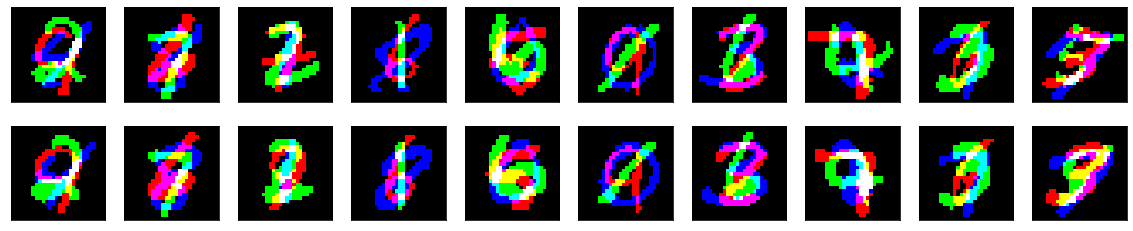

In [18]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(reconstructed[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

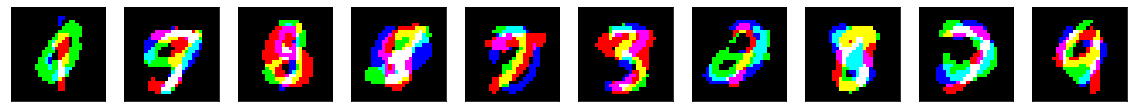

In [19]:
import numpy as np

nr_examples = 2000 
generated = np.zeros((nr_examples, 28, 28, 3))
decoder = keras.Model(decoder_input, decoded)

for i in range(3):
    z = np.random.randn(nr_examples, 8)
    generated[:,:,:,[i]] = decoder(z).mode()

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(generated[i-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [20]:
cov = net.check_class_coverage(data=generated, tolerance=0.98)
pred, _ = net.check_predictability(data=generated)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 27.50%
Predictability: 44.90%
